## Simulation-Based/Likelihood-Free Inference Quick Start

We would like to perform inference on a model's parameters $\theta$ given observations $\{x\}_i$:
$$ P(\theta | \{x\}_i)$$

We normally do this with Bayes rule:
$$ P(\theta | \{x\}_i) \propto P(\{x\}_i|\theta) P(\theta),$$
which relies on the likelihood function $P(\{x\}_i|\theta)$.

However, what if we don't know the Likelihood? What if all we can do is simulate outputs $x$ given $\theta$? $$x\sim \text{Simulator}(\theta)$$

Well say we have a simulator. Then we can simulate enough examples such that we can measure the frequency of examples reproducing the data (or getting close to it). This is called Approximate Bayesian Computation, or ABC:

![ABC](https://upload.wikimedia.org/wikipedia/commons/b/b9/Approximate_Bayesian_computation_conceptual_overview.svg)
(https://upload.wikimedia.org/wikipedia/commons/b/b9/Approximate_Bayesian_computation_conceptual_overview.svg)

But, what if the simulation is very expensive, and the data is high dimensional? Then we would need to run far too many simulations. E.g., images of a galaxy - it is notoriously hard to include all relevant physics to create a galaxy "correctly"

So we turn to Likelihood-Free Inference. Instead of needing to call the simulation over and over, we instead run it only a few times, and fit a function:

$$P(\theta|x)$$

for several examples of $\{\theta, x\}_i$, such that $\sum_i P(\theta|x)$ is maximized over the data.

### Density estimation

But what is $P(\theta|x)$ and how can we ensure it's normalized?

This is where density estimation-based LFI (DELFI) comes into play. We would like to fit a distribution over $\theta$, rather than a point-to-point function. One example is we would like to fit a function that predicts $(\mu, \sigma)$ for a 1D Gaussian. I.e.,

$$P(\theta|x) = \mathcal{N}(\mu=f_1(x), \sigma=f_2(x))$$

Then we know the function is normalized. And we maximize the likelihood of that Gaussian over the dataset by tweaking the parameters of $f_1$ and $f_2$. This can be done with piecewise Linear Regression (=Neural Networks), with some imposed smoothness regularization on $f_i$ so they don't overfit.

Furthermore, if one does not expect the posterior to look Gaussian (or a Gaussian mixture model), one can turn to "Normalizing Flows".

A normalizing flow is a flexible transformation between probability distributions:

![](https://i.imgur.com/582oadY.png)

A normalizing flow learns an invertible dynamical model for samples of the distribution. Sample a Gaussian, and go forward through the dynamical model to sample the learned distribution. Invert the model and go backward from a sample to the compute the likelihood.

![](https://1.bp.blogspot.com/-_mAChw7K2jI/XSDymvBPUbI/AAAAAAAARdc/clDlJ92t4cM9Hf4_6uvZninyH7G4cj8EACLcBGAs/s1600/forward.gif)

Each step is autoregressive^ (=change in y depends on x, followed by change in x depends on y), allowing it to be invertible. The invertibility implies normalization, since we aren't creating additional MC samples.

If you learn the dynamics with a flexible model, like a neural network, you can actually model an arbitrary distribution. This is great for non-Gaussian distributions.

For an astronomy example, check out this paper where we learn an accurate data-driven HR diagram directly from Gaia data with a normalizing flow (SNLE). No theory and no assumption of Gaussianity: https://arxiv.org/abs/1908.08045

![](https://astroautomata.com/assets/images/flow.png)

Modern LFI techniques model $P(\theta|x)$ as normalizing flows, to learn very flexible likelihoods. Here is the procedure:

1. Optionally learn a compression of $x$ to a smaller number of features.
2. Learn a normalizing flow that maximizes $P(\theta|x)$. We can then both sample and evaluate the likelihood of samples.

## Explicit Learned Compression

Recall: Fisher information is
$$F_{ij} = \vert d^2 \log P(\theta|\{x\})/d\theta^2\rvert$$
It tells you how "sharp" the surface of the likelihood about the maxima for your dataset. The sharper the likelihood is, the better you know your parameters! This is made explicit by the *Cramer-Rao* bound which gives you a limit on inferring your parameters.

An optimal compression of the data, if you know the likelihood, is given by:
$$t_\theta = \nabla_\theta log(P(\{x\}|\theta, \phi))$$

$\theta$ is your parameters you care about, $\phi$ is the nuisance parameters. This serves to preserves Fisher information.

One can also use handwritten summaries of the data (e.g., power spectrum).

However, with modern neural density estimators, one can feed the raw data directly into the normalizing flow, and it will automatically find a way to maximize predictive accuracy of $\theta$ using the dataset. One potentially could extract analytic forms of the summary features using methods from https://arxiv.org/abs/2006.11287.

# Likelihood-free Inference Tutorial:

Say that there is the following *true* model---a 2D Gaussian with known width:

$$(x_1, x_2) \sim \mathcal{N}(\mu, \Sigma=0.25 I)$$

The true vector for the Gaussian is $\mu = (3, -1.5)$, which we are unaware of. We make 5 observations and attempt to reconstruct a posterior over $\mu$.

The likelihood of this model is given by $$P(x|\mu) \sim \exp\left({(x_1-\mu_1)^2 + (x_2- \mu_2)^2\over 2 \cdot 0.25}\right),$$
which gives us a way to recover the parameter given data and a prior: $P(\mu|x) \sim P(x|\mu) P(\mu)$.


But now, say that **we don't know this likelihood**. Pretend we are not given the likelihood of a Gaussian. We only know how to draw samples from a Gaussian: this is our "simulation."

#### How can we compute a distribution over $\mu$, without a likelihood?

## Likelihood-free Inference

For LFI, you need to provide two ingredients:

1. a prior distribution that allows to sample parameter sets (your guess at $\mu$)
2. a simulator that takes parameter sets and produces simulation outputs (samples of a Gaussian with a given $\mu$)

For example, let's pretend we have a reasonable idea that $\mu$ is within $[-10, 10]$ with uniform probability. We also have our simulator that generates samples of a Gaussian.

# Getting started with `sbi`

In [1]:
import torch
import sbi.utils as utils
from sbi.inference.trainers.base import infer
from sbi.inference import NPE, NRE
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let's write out our uniform prior:

In [2]:
prior = utils.BoxUniform(
    low=torch.tensor([-10., -10.]),
    high=torch.tensor([10., 10.])
)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

This will be used to generate proposals for $\mu$. \
Now, let's write out our simulator for a given $\mu$:

In [4]:
def simulator(mu):
    # Generate samples from N(mu, sigma=0.5)

    return mu + 0.5 * torch.randn_like(mu)

simulator = process_simulator(simulator, prior, is_numpy_simulator=prior_returns_numpy)

In [5]:
simulator(
    torch.tensor([
    [1, 8.], [3., 5.], [-7., -3.]])
)

#check_sbi_inputs(simulator, prior)


tensor([[ 1.8096,  8.3579],
        [ 3.1571,  5.3809],
        [-7.0226, -3.4546]])

So here are samples of each simulation. Now, we will use this simulator with Likelihood-Free Inference to construct a distribution over potential mu values:

#### Step 1: Let's learn a likelihood from the simulator:

The likelihood is a type of "normalized" Neural Network---called a "normalizing flow".

In [74]:
num_sim = 2000
posterior = infer(
    simulator,
    prior,
    # See glossary for explanation of methods.
    #    SNRE newer than SNLE newer than SNPE.
    # method='SNPE', # Very fast sampling, but maybe worse accuracy.
    # method='SNLE',
    method='SNRE',
    num_workers=-1,
    num_simulations=num_sim)

TypeError: For multiprocessing, we switch to numpy arrays. Make sure to preprocess your simulator with `process_simulator` to handle numpy arrays.

In [6]:
inference = NRE(prior=prior)

num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

inference = inference.append_simulations(theta, x)
density_estimator = inference.train()

theta.shape torch.Size([2000, 2])
x.shape torch.Size([2000, 2])
 Neural network successfully converged after 62 epochs.

In [7]:
posterior = inference.build_posterior(density_estimator)

c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\sbi\inference\posteriors\mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Now we have a neural network that acts as our likelihood!

## Step 2, let's record our 10 "observations" of the true distribution:

In [12]:
n_observations = 10
observation = torch.tensor([3., -1.5])[None] + 0.5*torch.randn(n_observations, 2)


In [9]:
import seaborn as sns
from matplotlib import pyplot as plt

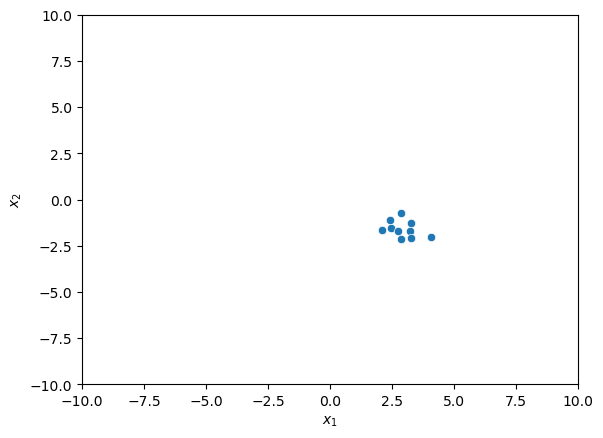

In [13]:
sns.scatterplot(x=observation[:, 0], y=observation[:, 1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

We can now use our learned likelihood (a neural network) to do inference on $\mu$! The way the problem is structured on the neural net side, we need to manually include all observations separately. But we can make samples of a single datapoint like so:

In [14]:
samples = posterior.sample((1000,), x=observation[0])

Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

C:\Users\vtard\AppData\Local\Temp\ipykernel_16524\804504734.py:3: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the log-probability up to a normalizing constant. Use `.potential()` instead.
  log_probability = posterior.log_prob(samples, x=observation[0])
C:\Users\vtard\AppData\Local\Temp\ipykernel_16524\804504734.py:3: UserWarning: The log-probability is unnormalized!
  log_probability = posterior.log_prob(samples, x=observation[0])
C:\Users\vtard\AppData\Local\Temp\ipykernel_16524\804504734.py:4: DeprecationWarning: you passed deprecated arguments **kwargs: ['fig_size'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  out = pairplot(samples, limits=[[-10,10],[-10,10]], fig_size=(6,6))


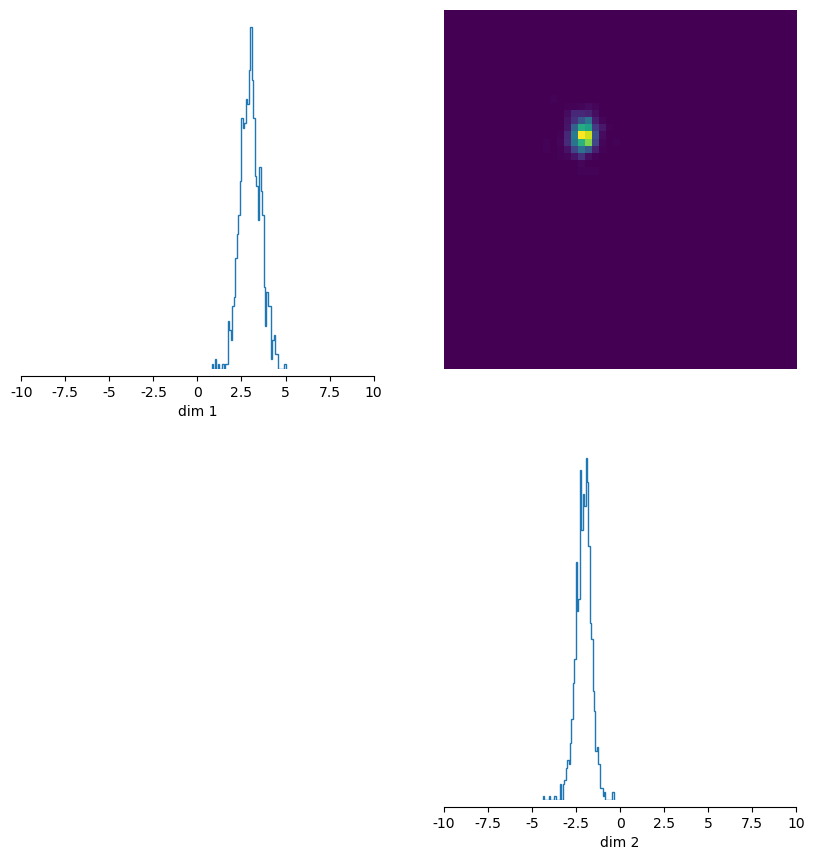

In [15]:
from sbi.analysis.plot import pairplot

log_probability = posterior.log_prob(samples, x=observation[0])
out = pairplot(samples, limits=[[-10,10],[-10,10]], fig_size=(6,6))

Let's create a grid of $\mu$ close to the expected value of $(3, -1.5)$, and calculate the total log likelihood for each value:

In [16]:
import numpy as np

bounds = [3-1, 3+1, -1.5-1, -1.5+1]

mu_1, mu_2 = torch.tensor(np.mgrid[bounds[0]:bounds[1]:2/50., bounds[2]:bounds[3]:2/50.]).float()

samples = torch.cat(
    (mu_1.reshape(-1, 1), mu_2.reshape(-1, 1)),
    dim=1
)

Let's calculate the log probability across the grid. One can usually use `posterior.log_prob`, but one can also vectorize it as follows:

C:\Users\vtard\AppData\Local\Temp\ipykernel_16524\3037865882.py:9: UserWarning: `.log_prob()` is deprecated for methods that can only evaluate the log-probability up to a normalizing constant. Use `.potential()` instead.
  log_probability = posterior.log_prob(samples, x=observation)
C:\Users\vtard\AppData\Local\Temp\ipykernel_16524\3037865882.py:9: UserWarning: The log-probability is unnormalized!
  log_probability = posterior.log_prob(samples, x=observation)
c:\Users\vtard\anaconda3\envs\pytorch\Lib\site-packages\sbi\utils\user_input_checks.py:585: UserWarning: An x with a batch size of 10 was passed. Unless you are using `sample_batched` or `log_prob_batched`, this will be interpreted as a batch of independent and identically distributed data X={x_1, ..., x_n}, i.e., data generated based on the same underlying(unknown) parameter. The resulting posterior will be with respect to the entire batch, i.e,. p(theta | X).
  warn_on_batched_x(batch_size=input_x_shape[0])


Text(0, 0.5, '$\\mu_2$')

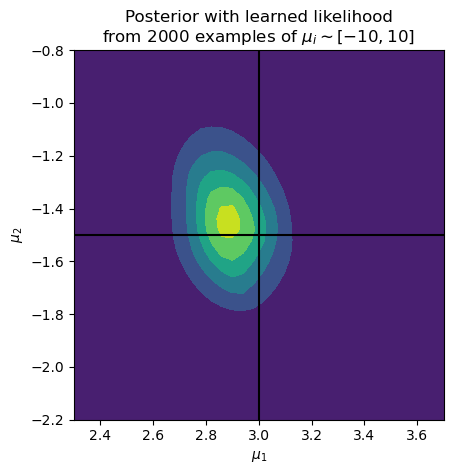

In [24]:
# log_prob = sum([
#     posterior.log_prob(observation)[:, 0] + posterior._prior.log_prob(samples)
#     for i in range(len(observation))
# ]).detach()


# prob = torch.exp(log_prob)

log_probability = posterior.log_prob(samples, x=observation)
prob = torch.exp(log_probability)


plt.plot([2, 4], [-1.5, -1.5], color='k')
plt.plot([3, 3], [-0.5, -2.5], color='k')
# plt.contourf(prob.reshape(*mu_1.shape), extent=bounds, origin='lower')
plt.contourf(prob.reshape(*mu_1.shape), extent=bounds, origin='lower')
plt.axis('scaled')
plt.xlim(2+0.3, 4-0.3)
plt.ylim(-2.5+0.3, -0.5-0.3)
plt.title('Posterior with learned likelihood\nfrom 2000 examples of'+r' $\mu_i\sim[-10, 10]$')
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')

Text(0, 0.5, '$\\mu_2$')

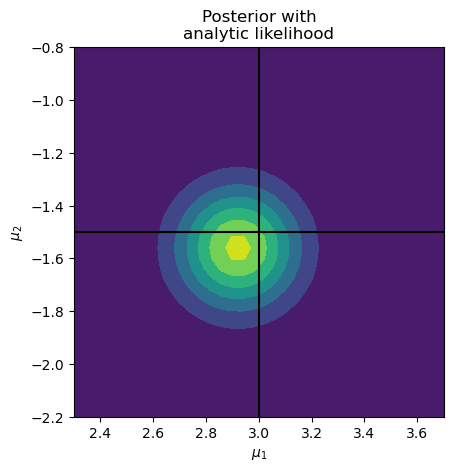

In [19]:
true_like = lambda x: -((x[0] - mu_1)**2 + (x[1] - mu_2)**2)/(2*0.5**2)
log_prob = sum([true_like(observation[i]) for i in range(len(observation))])
prob = torch.exp(log_prob)
plt.plot([2, 4], [-1.5, -1.5], color='k')
plt.plot([3, 3], [-0.5, -2.5], color='k')
plt.contourf(prob.reshape(*mu_1.shape), extent=bounds, origin='lower')
plt.axis('scaled')
plt.xlim(2+0.3, 4-0.3)
plt.ylim(-2.5+0.3, -0.5-0.3)
plt.title('Posterior with\nanalytic likelihood')
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')

### Hogg Project

Data: Kepler observed multiplicity histogram

Define $ p(P|\theta), p(i|\theta), p(N|\theta) $

Find out what $\theta$ give rise to the multiplicity observed

In [1]:
# importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import loguniform
import scipy.stats as stats
import mr_forecast
from astropy.io import ascii
from scipy.stats import bernoulli
import math

In [2]:
# loading and selecting data

# Planet candidates
all_candidates = pd.read_csv("cumulative_2024.10.01_08.07.06.csv",delimiter=",", comment="#")
masked_cand = all_candidates.where((all_candidates['koi_period'] > 6.25)&(all_candidates['koi_period']< 400))
masked_cand = masked_cand.where((masked_cand["koi_prad"]>0.5)&(masked_cand["koi_prad"]<32))
masked_cand = masked_cand.where((masked_cand["koi_slogg"]>4))
masked_cand = masked_cand.where((masked_cand["koi_smass"]<1.2)&(masked_cand["koi_smass"]>0.8)).dropna(how='all')

# Stars
all_dr25 = pd.read_csv("result.csv")
selected_stars = all_dr25.where((all_dr25["log(g)"]>4)&(all_dr25["Mass"]<1.2)&(all_dr25["Mass"]>0.8)).dropna(how='all')
len(selected_stars)

data = ascii.read("nph-nstedAPI.txt")  
all_stars = data.to_pandas()
all_stars_in_selected_stars = all_stars[all_stars['kepid'].isin(selected_stars["KIC"])]


In [43]:
len(masked_cand)

2058

In [58]:
# P(detection|SNR)

def p_det_given_snr(snr, bl=8.06,cl=8.11,dl=0.995):
    
    return dl - dl/(1+(snr/cl)**bl)

## Forward model:
1) Choose random star from selected_stars

2) Inject planetary system with m <= 10 planets drawn from multiplicity function
3) Planets assigned random period 6.25 < P < 400 days drawn from log-uniform distribution
4) Innermost planet assigned random radius drawn from a double-sided power law (DSPL) dist. 
5) Radii of subsequent planets drawn from Gaussian distribution centered at the innermost planet’s radius
6) Generate m proposal and check for Hill stability (need to estimate mass for each planet and calculate semi-major axes) 
7) Calculate how many planets in system will transit and find fraction of detectable transiting planets in the system

In [142]:
def select_stars(catalog_df):
    return catalog_df.sample(1)

def inject_planets(distribution,b_m,plus,minus):

    a = np.random.choice([0,1],p=[0.5,0.5])
    if a == 1:
        a1 = np.random.uniform(low=b_m-minus,high=b_m)
    elif a == 0:
        a1 = np.random.uniform(low=b_m,high=b_m+plus)

    if distribution == "constant":
        m = np.round(a1)

    if distribution == "uniform":
        m = 0
        while m<1:
            m = np.ceil(np.random.uniform(low = a1, high = 10))

    if distribution == "zipfian":
        m = 11
        while m > 10 or m < 1:
            m = np.random.zipf(1+a1)
            m = np.round(m)
    
    return int(m)

def assign_periods(planets):
    periods = []
    for i in range(planets):
        periods.append(loguniform.rvs(6.25, 400, size=1)[0])
    periods = np.sort(periods)
    return np.array(periods)


def assign_radii(planets,rcrit, alpha_small, alpha_big, sigma, rmin = 0.5, rmax = 32):
    # Initialize an empty list to store the sampled radii
    radii = []
    
    # Generate uniform random values for the log of radii
    u = np.random.rand(1)[0]
    # Define total normalization factor
    norm_small = (np.log10(rcrit) - np.log10(rmin))**alpha_small
    norm_big = (np.log10(rmax) - np.log10(rcrit))**alpha_big
    total_norm = norm_small + norm_big
    
    if u < norm_small / total_norm:
        # Sample from the region [rmin, rcrit] with prob ~ (log10(r) - log10(rmin))^alpha_small
        prob_r = np.random.uniform(np.log10(rmin), np.log10(rcrit))
        radii.append(10**(prob_r))
    else:
        # Sample from the region [rcrit, rmax] with prob ~ (log10(r) - log10(rcrit))^alpha_big
        prob_r = np.random.uniform(np.log10(rcrit), np.log10(rmax))
        radii.append(10**(prob_r))

    if planets>1:
        for i in range(planets-1):
            radii.append(np.abs(np.random.normal(radii[0], sigma, 1)[0]))

    return np.array(radii)

def get_axes(periods,mstar,masses):
    G = 8.89e-10  # AU cubed per Earth mass day squared
    return (periods**2 *G*(mstar*333000+masses)/(4*np.pi**2))**(1/3)

def hill_stability(radii,mstar,periods,masses,r_crit=2*np.sqrt(3)):
    
    stable = True

    if len(radii)> 1: 
        
        if masses is not None:
            axes = get_axes(periods,mstar,masses) 

            for i in range(len(radii)-1):
                rh = ((masses[i]+masses[i+1])/(3*mstar*333000))**(1/3) * ((axes[i]+axes[i+1])/2)
                if (axes[i+1]-axes[i])/rh <= r_crit:
                    stable = False
                    break
            
            if stable == True & len(radii) >= 3:
                rh_in = ((masses[0]+masses[1])/(3*mstar*333000 ))**(1/3) * ((axes[0]+axes[1])/2)
                rh_out = ((masses[-2]+masses[-1])/(3*mstar*333000 ))**(1/3) * ((axes[-2]+axes[-1])/2)

                delta_in = (axes[1]-axes[0])/rh_in
                delta_out = (axes[-1]-axes[-2])/rh_out
                if delta_in + delta_out <= 18:
                    stable = False
        else:
            stable = False

    return stable

def impact_params(planets,periods,mstar,masses,rstar,sigma):
    axes = get_axes(periods,mstar,masses)
    cosi1 = np.random.uniform(low = 0, high=1)
    
    b1 = (axes[0]*23455)/(rstar*109.1) * cosi1
    bs = [b1]
    if planets > 1:
        for i in range(planets):
            if i == 0:
                pass
            elif i > 0 :
                delta_i = np.deg2rad(np.random.rayleigh(scale = sigma))
                bn = (axes[i]*23455/(rstar*109.1))*np.abs(cosi1*np.cos(delta_i)-(np.sqrt(1-cosi1**2))*np.sin(delta_i))
                
                bs.append(bn)
                
    return np.array(bs)

def transit_check(impact_param,rstar,radius):
    if impact_param < (1+(radius/(rstar*109.1))):
        return True
    else:
        return False

def snr(obs_time_total,period,rp,rs,ms,mp,b,kmag,dutycycle):
    axes = get_axes(period,ms,mp)*23455
    #T_obs = period/np.pi*np.arcsin((np.sqrt(np.abs((rp+rs*109.1)**2-(b*rs*109.1)**2)))/axes)
    total_t = 2*period/(2*np.pi*axes)*np.sqrt((rp+rs*109.1)**2-b**2)
    full_t = 2*period/(2*np.pi*axes)*np.sqrt((rp-rs*109.1)**2-b**2)
    w = (total_t+full_t)/2
    gamma = 10**(-0.4*(kmag-12))*(1.486e10)*dutycycle
    read_noise = 120/0.66
    new_snr = (np.sqrt(obs_time_total/period))*w*(rp/(rs*109.1))**2*np.sqrt(gamma-read_noise)/(np.sqrt(total_t-w*(rp/(rs*109.1))**2))
    
    #new_snr = (np.sqrt(obs_time_total/period))*(rp/(rs*109.1))**2/cdpp
    #print(f"new: {new_snr}")
    return new_snr


In [117]:
def create_stable_planet_system(star,rcrit, alpha_small, alpha_big, sigma,b_m,plus,minus,dist):
    
    systems = []
    #star = select_stars(star_catalog_df)
    planet_number = inject_planets(dist,b_m,plus,minus)

    periods = assign_periods(planet_number)
    radii = assign_radii(planet_number,rcrit, alpha_small, alpha_big, sigma)
    masses = mr_forecast.Rpost2M(radii, unit='Earth')
    hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
    if hill_stable == True:
        for i in range(planet_number):
            systems.append([i, periods[i], radii[i],masses[i]])
    if len(systems) > 0:
        return np.array(systems)
    else: 
        return None

def create_stable_planet_system_of_transits(star,rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,plus,minus,dist):
    
    systems = []
    
    #star = select_stars(star_catalog_df)
    planet_number = inject_planets(dist,b_m,plus,minus)

    periods = assign_periods(planet_number)
    radii = assign_radii(planet_number,rcrit, alpha_small, alpha_big, sigma)
    masses = mr_forecast.Rpost2M(radii, unit='Earth')
    hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
    if hill_stable == True:
        #masses = mr_forecast.Rpost2M(radii, unit='Earth')
        bs = impact_params(planet_number,periods,float(star["mass"]),masses,float(star["radius"]),sigma_i)
        for i in range(planet_number):
            if transit_check(bs[i],float(star["radius"]),radii[i]) == True:
                systems.append([i, periods[i], radii[i],masses[i],bs[i]])
    if len(systems) > 0:
        
        return np.array(systems)
    else: 
        return None


def is_transit_detected(obs_time_total,period,rp,rs,ms,mp,b,kmag,dutycycle,bl=8.06,cl=8.11,dl=0.995):
    snr_val = snr(obs_time_total,period,rp,rs,ms,mp,b,kmag,dutycycle)
    if math.isnan(snr_val) == False:
        prob = p_det_given_snr(snr_val,bl,cl,dl)
        detected = bernoulli.rvs(prob)
    else:
        detected = 0
    return detected, snr_val


In [118]:
def create_transit_data(star_catalog_df, rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,plus,minus,dist,n=len(masked_cand)):
    
    transits = []
    snrs = []
    sys_dicts = []
    num_trans = 0

    while num_trans < n:
        star = select_stars(star_catalog_df)
        for iter in range(1000):
            system_attempt = create_stable_planet_system_of_transits(star,rcrit, alpha_small, alpha_big, sigma,sigma_i,b_m,plus,minus,dist)
            if system_attempt is None:
                pass
            elif system_attempt is not None:
                trans_in_sys = []
                num_planets = len(system_attempt[:,0])
                
                #bs = impact_params(num_planets,system_attempt[1,:],float(star["mass"])*332943,system_attempt[3,:],float(star["radius"]),sigma_i)
                if star["rrmscdpp06p0"] is not np.nan:
                    for i in range(num_planets):
                    
                        b = system_attempt[i,4]
                        
                        detected_or_not, snr = is_transit_detected(float(star["dataspan"]),system_attempt[i,1],system_attempt[i,2],float(star["radius"]),float(star["mass"]),system_attempt[i,3],b,float(star["kepmag"]),float(star["dutycycle"]))
                        
                        if detected_or_not == 1:
                            trans_in_sys.append(system_attempt[i,:])
                            snrs.append(snr)
                            
                    trans_in_sys = np.array(trans_in_sys)
                    if len(trans_in_sys) > 0:
                        num_trans += len(trans_in_sys)
                        sys_dict = {"detected planets" : len(trans_in_sys),
                                    "planet periods": trans_in_sys[:,1],
                                    "planet radii": trans_in_sys[:,2],
                                    "planet masses": trans_in_sys[:,3]}
                        transits.append(np.array(trans_in_sys))
                        sys_dicts.append(sys_dict)
                        print(num_trans)
                        break
    
    # for system in systems:
    #     trans_in_sys = []
    #     num_planets = len(system[0]) 
    #     for i in range(num_planets):
    #         detected_or_not = is_transit_detected(star["dataspan"],system[1][i],system[2][i],star["radius"],star["rrmscdpp06p0"],8.06, 8.11,0.995)
    #         if detected_or_not == 1:
    #             trans_in_sys.append(system[:,i])
    #     transits.append(trans_in_sys)

    return sys_dicts
    

In [125]:
# rcrit = np.random.uniform(low=0.5,high=32)
# alpha_small = np.random.uniform(low=-1.1,high=5)
# alpha_big = np.random.uniform(low = alpha_small, high = 10)
# sigma = np.random.uniform(low=0.1,high=10)
# sigma_i = np.random.uniform(low=0.1,high=10)

rcrit = 2.53
alpha_small = 2.4
alpha_big = 2.61
sigma = 0.25
sigma_i = 5.8

all_obs = []


for i in range(10):
    a = create_transit_data(all_stars_in_selected_stars,rcrit, alpha_small, alpha_big, sigma,sigma_i,0.51,1.25,1.77,dist = "uniform")
    obs_mult = []
    for j in a:
        obs_mult.append(j["detected planets"])
    hist1, _ = np.histogram(obs_mult,bins=range(1,12))

    all_obs.append(hist1)


C:\Users\vtard\AppData\Local\Temp\ipykernel_32996\3322338685.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  hill_stable = hill_stability(radii, float(star["mass"]) , periods, masses) #convert star mass from solar mass to earth mass units
C:\Users\vtard\AppData\Local\Temp\ipykernel_32996\3322338685.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bs = impact_params(planet_number,periods,float(star["mass"]),masses,float(star["radius"]),sigma_i)
C:\Users\vtard\AppData\Local\Temp\ipykernel_32996\3322338685.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if transit_check(bs[i],float(star["radius"]),radii[i]) == True:
C:\Users\vtard\AppData\Local\Temp\ipykernel_32996\763934302.py:24: F

Radius range out of model expectation. Returning None.
2
4
5
Radius range out of model expectation. Returning None.
6
Radius range out of model expectation. Returning None.
7
8
11
12
13
14
15
16
17
Radius range out of model expectation. Returning None.
18
19
21
22
23
24
Radius range out of model expectation. Returning None.
25
26
27
28
29
30
32
33
Radius range out of model expectation. Returning None.
34
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Radius range out of model expectation. Returning None.
52
53
54
57
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
58
59
61
62
64
65
66
67
Radius range out of model expectation. Returning None.
70
71
72
73
74
Radius range out of model expectation. Returning None.
Radius range out of model expectation. Returning None.
75
76
77
Radius range out of model expectation. Re

In [126]:
np.save("all_obs_uniform.npy",all_obs)
#np.save("all_under_constant.npy",all_under)

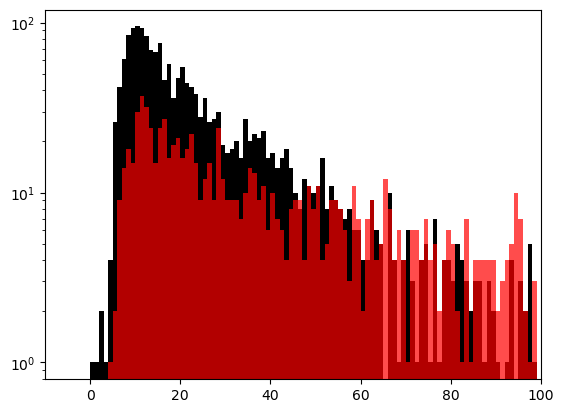

In [409]:
plt.hist(masked_cand["koi_model_snr"],bins=range(0,100),color="black")
plt.hist(c,bins=range(0,100),color="red",alpha=0.7)
plt.xlim(-10,100)
plt.yscale("log")

In [149]:
hists = []
for i in range(30):
    ms = []
    for i in range(2058):
        ms.append(inject_planets("zipfian",0.86,0.28,0.29))
    hist,_,=np.histogram(ms,bins=range(1,12))
    hists.append(hist)

hists = np.array(hists)

In [150]:
all_obs_total = np.concatenate((np.load("all_obs.npy"),np.load("all_obs2.npy")),axis=0)
# all_under_total = np.concatenate((np.load("all_under.npy"),np.load("all_under2.npy")),axis=0)

all_obs_mean = np.mean(all_obs_total,axis=0)
all_obs_std = np.std(all_obs_total,axis=0)

#all_under_mean = np.mean(all_under_total,axis=0)
#all_under_std = np.std(all_under_total,axis=0)

all_under_mean = np.mean(hists,axis=0)
all_under_std = np.std(hists,axis=0)

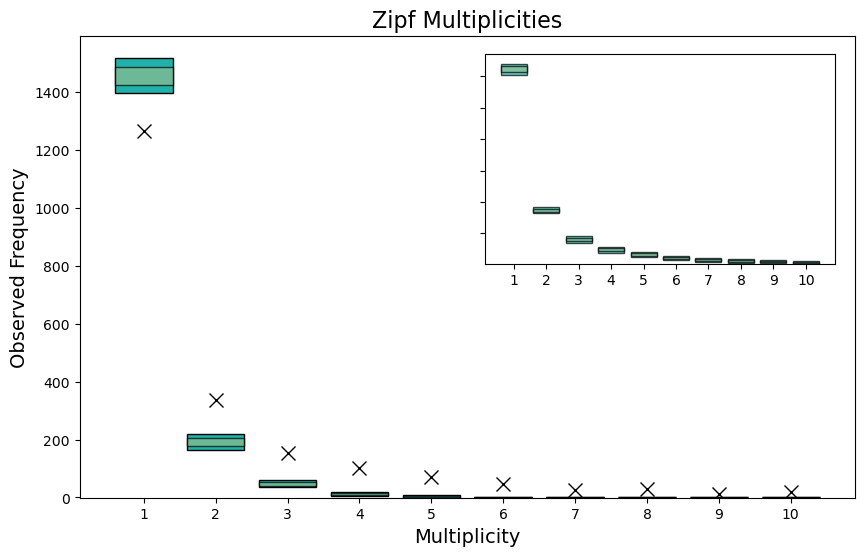

In [151]:
# Updated plot with segmented bars centered around the mean, and stacked standard deviation boxes
fig, ax = plt.subplots(figsize=(10, 6))

# Main plot with segmented bars for 'all_obs'
for i, (mean, std) in enumerate(zip(all_obs_mean, all_obs_std), start=1):
    # Bottom segment from (mean - std) to mean
    ax.bar(i, 4*std, bottom=mean-2*std, color="lightseagreen", edgecolor="black", alpha=1, align="center")
    # Top segment from mean to (mean + std)
    ax.bar(i, 2*std, bottom=mean-std, color="darkseagreen", edgecolor="black", alpha=0.7, align="center")
    ax.plot(i,hist[i-1],"x",markersize = 10,color="black")
    #ax.bar(i, mean, bottom=None, color="darkseagreen", edgecolor="black", alpha=1, align="center")

ax.set_xlabel("Multiplicity", fontsize=14)
ax.set_ylabel("Observed Frequency", fontsize=14)
ax.set_title("Zipf Multiplicities", fontsize=16)
ax.set_xticks(range(1,11))

# Inset plot for 'all_under' with segmented bars
inset_ax = fig.add_axes([0.53, 0.5, 0.35, 0.35])
for i, (mean, std) in enumerate(zip(all_under_mean, all_under_std), start=1):
    # Bottom segment from (mean - std) to mean
    inset_ax.bar(i, 4*std, bottom=mean - 2*std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")
    # Top segment from mean to (mean + std)
    inset_ax.bar(i, 2*std, bottom=mean-std, color="darkseagreen", edgecolor="black", alpha=0.7, align="center")
    #inset_ax.bar(i, std, bottom=mean + std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")

inset_ax.set_xticks(range(1,11))  # Focus on the first 10 multiplicities
#inset_ax.set_yticks([0, 500, 1000, 1500, 2000])
inset_ax.set_yticklabels([])
#inset_ax.set_xticklabels([])

# Show plot
plt.show()


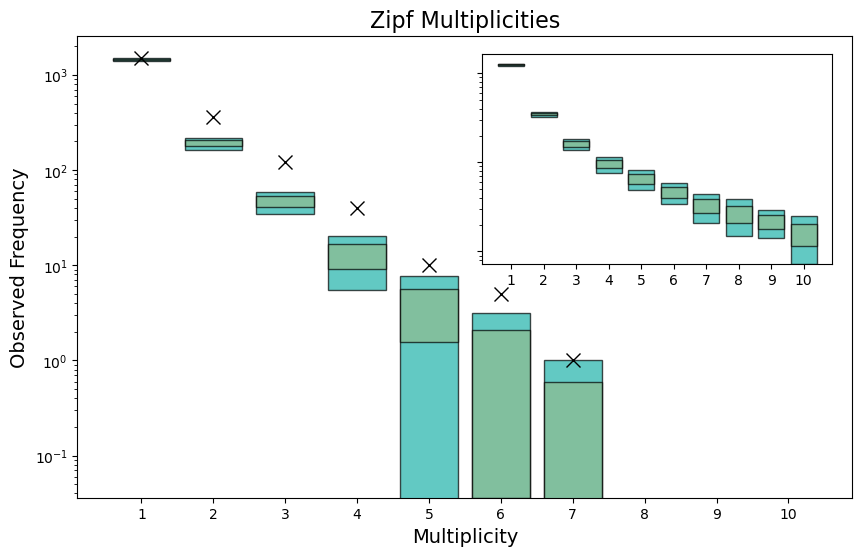

In [152]:
# Updated plot with segmented bars centered around the mean, and stacked standard deviation boxes


hist, _  = np.histogram(masked_cand["koi_tce_plnt_num"],range(1,12))

fig, ax = plt.subplots(figsize=(10, 6))



# Main plot with segmented bars for 'all_obs'
for i, (mean, std) in enumerate(zip(all_obs_mean, all_obs_std), start=1):
    # Bottom segment from (mean - std) to mean
    ax.bar(i, 4*std, bottom=mean - 2*std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")
    # Top segment from mean to (mean + std)
    ax.bar(i, 2*std, bottom=mean-std, color="darkseagreen", edgecolor="black", alpha=0.7, align="center")
    ax.plot(i,hist[i-1],"x",markersize = 10,color="black")
    #ax.bar(i, std, bottom=mean + std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")

ax.set_yscale("log")
ax.set_xlabel("Multiplicity", fontsize=14)
ax.set_ylabel("Observed Frequency", fontsize=14)
ax.set_title("Zipf Multiplicities", fontsize=16)
ax.set_xticks(range(1,11))

# Inset plot for 'all_under' with segmented bars
inset_ax = fig.add_axes([0.53, 0.5, 0.35, 0.35])
for i, (mean, std) in enumerate(zip(all_under_mean, all_under_std), start=1):
    # Bottom segment from (mean - std) to mean
    inset_ax.bar(i, 4*std, bottom=mean - 2*std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")
    # Top segment from mean to (mean + std)
    inset_ax.bar(i, 2*std, bottom=mean-std, color="darkseagreen", edgecolor="black", alpha=0.7, align="center")
    #inset_ax.bar(i, std, bottom=mean + std, color="lightseagreen", edgecolor="black", alpha=0.7, align="center")

inset_ax.set_xticks(range(1,11))  # Focus on the first 10 multiplicities
inset_ax.set_yscale("log")
inset_ax.set_yticklabels([])
#inset_ax.set_xticklabels([])

# Show plot
plt.show()